# Hiérarchies de volumes englobants

Ce cours vise à vous introduire la notion de volume englobant et de hiérarchie pour accélérer les requêtes spatiales.

In [1]:
#Librairies utilisées pour ce cours

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import numpy as np
import scipy.signal
import math
import random

In [2]:
# Fonctions utilitaires pour des courbes et de l'aléatoire, peu important

# Tracé de courbes  
def plot_array(array, log = False, trace = False, filter_range = 1):
    if filter_range > 1:
        filtered = scipy.signal.medfilt(array, filter_range)
        plt.ylim(top=np.max(filtered)*1.05)
    if log:
        plt.semilogy(array)
    else:
        if trace:
            plt.plot(array)
        else:
            plt.scatter(np.arange(len(array)), array, s=1)

# Couleurs aléatoires
def rand_color() :
    from matplotlib.colors import hsv_to_rgb
    h = random.random()
    s = 0.2 * random.random() + 0.4
    v = 0.3 * random.random() + 0.7
    return hsv_to_rgb([h,s,v])

def pastel(color, amount=0.5):
    import matplotlib.colors as mc
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = mc.rgb_to_hsv(mc.to_rgb(c))
    return mc.hsv_to_rgb([c[0], amount*c[1], amount + (1-amount)*c[2]])
    
# Tracé de nuages de points
def plot_points(array, **args):
    if array.shape[1] == 2:
        plt.scatter(array[:,0], array[:,1], **args)
    else:
        ax = plt.gca(projection='3d')
        ax.scatter(array[:,0], array[:,1], array[:,2], **args)

# Mesure de performances
def perf(f, input, trials=5, iterations = 3):
    res = []
    for i in input:
        times = []
        for j in range(trials):
            start = time.perf_counter()
            for k in range(iterations):
                f(*i)
            end = time.perf_counter()
            times.append(end - start)
        res.append(sorted(times)[trials//2])
    return np.array(res)

# Génération aléatoire de directions
def rand_directions(size, dim = 2):
    # distribution normale sur tous les axes
    pts = np.random.normal(0,1,(size, dim))
    # points uniformes sur la sphere
    pts = pts / np.linalg.norm(pts, axis=1)[:, np.newaxis]
    return pts
    
# Génération aléatoires dans un disque
def rand_in_disk(size, center = np.array([0,0]), radius = 1):
    dim = len(center)
    pts = rand_directions(size, dim)
    # points uniforme dans la boule
    pts = pts * (np.random.uniform(0,1,size)**(1/dim))[:, np.newaxis]
    # recentrage et redimensionnement
    pts = center + radius * pts
    return pts

# Carré de la distance euclidienne
def sq_distance(pt1, pt2):
    diff  = pt1 - pt2
    return diff[0]*diff[0] + diff[1]*diff[1]

## Recherche du point le plus proche

Une première requête spatiale que nous pouvons aborder est la recherche du point le plus proche parmi un ensemble de points donnés. Commençons par générer un ensemble de points

In [3]:
pts = rand_in_disk(100)

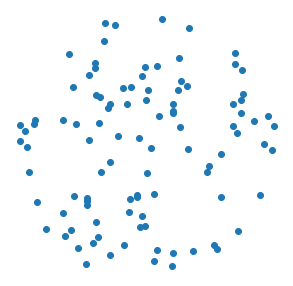

In [4]:
fig, ax = plt.subplots(figsize=(5,5))
plt.axis('off')
plot_points(pts)

### Approche Naïve

Nous pouvons maintenant proposer la recherche naïve du point le plus proche, simplement en recherchant linéairement dans le tableau de points celui qui minimise la distance à la requête.

In [5]:
def naive_nearest(pts, query):
    n = pts[0]
    d = sq_distance(n, query)
    for pt in pts[1:]:
        dc = sq_distance(pt, query)
        if dc < d:
            n = pt
            d = dc
    return n

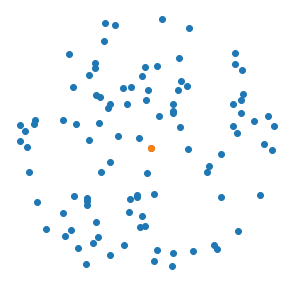

In [6]:
test_pt = naive_nearest(pts, [0,0])

fig, ax = plt.subplots(figsize=(5,5))
plt.axis('off')
plot_points(pts)
plot_points(np.array([test_pt]))

Nous pouvons désormais tester les temps de calcul de notre algorithme sur des ensembles de points allant de 1 à 1000 points.

In [7]:
nearest_inputs = [[rand_in_disk(n), rand_in_disk(1)[0]] for n in range(1, 1000)]

In [8]:
naive_perf = perf(naive_nearest, nearest_inputs)

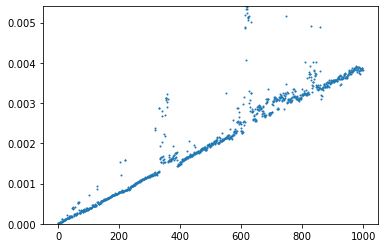

In [9]:
plot_array(naive_perf, filter_range=15)

Comme on pouvait s'en douter, l'algorithme est linéaire en le nombre de points. Notre but par la suite sera de faire mieux. Bien sûr, si le but est de ne faire qu'une requête de plus proche voisinage, il ne sera à rien d'espérer faire mieux, car sans organisation particulière des points, ils devront nécessairement tous être testés. Lorsque le nombre de requêtes avec le même ensemble de points augmente, il devient alors envisageable de réaliser un *précalcul* pour organiser les points, et ainsi rendre les requêtes plus efficaces.

### Boîte englobante alignée sur les axes

Pour accélérer les choses, une technique classique est d'utiliser des englobants. Un englobant dans le cadre d'une recherche de point le plus proche est un volume pour lequel il est facile de calculer la distance à un point. Ainsi, la distance de ce qui est à l'intérieur de l'englobant est nécessairement plus grande que la distance à l'englobant (vu qu'il faut rentrer dans l'englobant pour atteindre son contenu). En regroupant les points dans des englobants, on peut donc tester d'abord l'englobant, et si la distance à l'englobant est élevée, ne pas aller plus loin avec son contenu.

Ci dessous, je propose d'utiliser des *boîtes englobantes alignées sur les axes* (Axis Aligned Bounding Boxes abbréviées en AABB en anglais). Le fait d'être "alignée sur les axes" signifie que les côtés de la boîte sont parallèles aux axes du repère. Ci-dessous en 2D, les axes x et y. Il est donc possible de définir ces boîtes simplement à partir du minimum et du maximum de la boîte sur chaque axe. 

![boîte englobante alignée sur les axes](Images/aabb.png)

Dans le code ces deux bornes sont représentées par les points `min = (xmin,ymin)` et `max = (xmax, ymax)`.

In [10]:
class Box:
    def __init__(self, pt):
        self.min = pt[:]
        self.max = pt[:]
    
    def push(self, pt):
        self.min = np.minimum(self.min, pt)
        self.max = np.maximum(self.max, pt)

    def draw(self, color=None, **kwargs):
        if color is None:
            color = rand_color()
        corners = np.empty((4,2))
        corners[0] = self.min
        corners[1] = [self.max[0], self.min[1]]
        corners[2] = self.max
        corners[3] = [self.min[0], self.max[1]]
        plt.fill(corners[:,0], corners[:,1], facecolor=pastel(color, 0.2), zorder=0, **kwargs)
        plt.fill(corners[:,0], corners[:,1], facecolor='none', zorder=0, linewidth=1, edgecolor=color)

Pour contruire la boîte, les points sont ajoutés un à un, et le minimum et le maximum sur chaque axe sont conservés. Après avoir introduit tous les points, nous obtenons la boîte alignée sur les axes minimale qui englobe nos points.

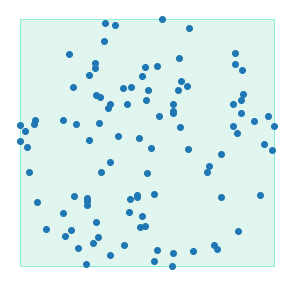

In [11]:
fig, ax = plt.subplots(figsize=(5,5))
plt.axis('off')

plot_points(pts)
b = Box(pts[0])
for pt in pts[1:]:
    b.push(pt)
b.draw()

La distance d'un point à une boîte est la longueur du plus court chemin permettant d'aller du point à la boîte. La méthode `nearest` fournie ci-dessous permet d'obtenir le point à l'intérieur de la boîte le plus proche du point fourni en paramètre. Si la requête est un point dans la boîte, le même point est retourné. Sinon le point est à la surface de la boîte. Le principe de cette fonction est que sur chaque axe (x ou y) on compare la coordonnées de la requête aux bornes de la boîte. Si la requête est plus petite que la borne minimale de la boîte, elle est en dehors de la boîte et le point le plus proche aura comme coordonnée sur cet axe la borne de la boîte. De même si la coordonnée est plus grande que la borne max. Sinon, le point le plus proche aura la même coordonnée que la requête, pour minimiser le terme de la distance correspondant à cet axe (on aura alors 0 en faisant la différence des coordonnées).

In [12]:
 class Box(Box):       
    def nearest(self, pt):
        n = np.zeros(2)
        for c in range(2):
            if pt[c] < self.min[c]:
                n[c] = self.min[c]
            elif pt[c] > self.max[c]:
                n[c] = self.max[c]
            else:
                n[c] = pt[c]
        return n
    
    def sq_distance(self, pt):
        n = self.nearest(pt)
        return sq_distance(n, pt)

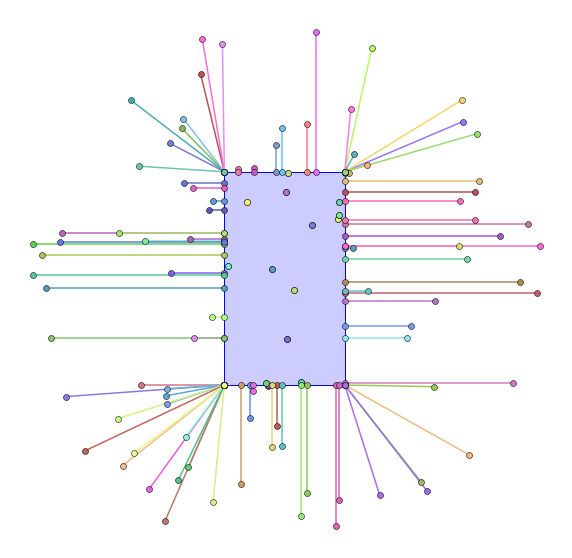

In [13]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')

b = Box(rand_in_disk(1, [-0.3,-0.3], 0.2)[0])
b.push(rand_in_disk(1, [0.3,0.3], 0.2)[0])
b.draw(color="blue")

nearest_pts = np.array([b.nearest(p) for p in pts])

for pt, npt in zip(pts, nearest_pts):
    c = rand_color()
    plt.plot([pt[0], npt[0]], [pt[1], npt[1]], color=c)
    plot_points(np.array([pt, npt]), color=c, linewidth=0.5, edgecolor='black', zorder=3)
    
plt.show()

## Des paquets de points

Pour accélérer les recherches de point le plus proche, une approche classique est de séparer les points en groupes, disposant chacun d'un englobant. Avant de tester les points du groupe, on teste la distance de l'englobant. S'il est trop loin, il est inutile de traiter les points à l'intérieur. Dans l'exemple ci-dessous on répartit les points en coupant l'espace en quatre.

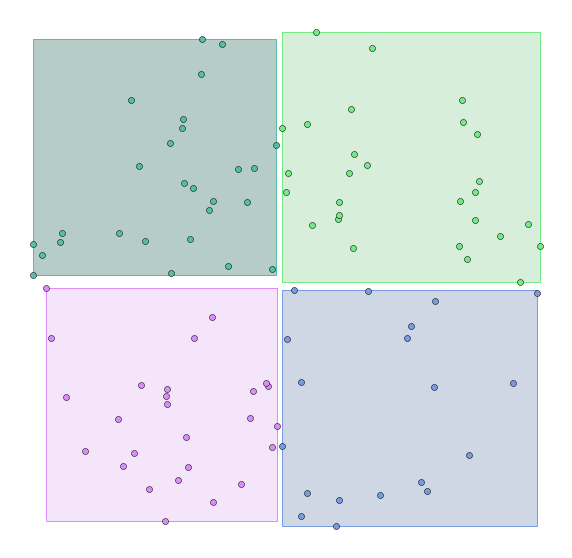

In [14]:
def split_pts(pts, nb_intervals):
    # conteneurs pour stocker les paquets de points
    packets = []
    boxes = []
    # longueur des côtés des paquets
    box_length = 2 / nb_intervals
    # répartition des points en paquets
    for i in range(nb_intervals):
        # intervalle selon x
        xmin = i * box_length - 1
        xmax = (i+1) * box_length - 1
        for j in range(nb_intervals):
            # intervalle selon y
            ymin = j * box_length - 1
            ymax = (j+1) * box_length - 1
            # création du paquet
            packet = []
            for pt in pts:
                if pt[0] >= xmin and pt[0]< xmax and pt[1] >= ymin and pt[1] < ymax:
                    packet.append(pt)
            packets.append(np.array(packet))
            # création de sa boîte englobante
            box = None
            if len(packet) > 0:
                box = Box(packet[0])
                for pt in packet[1:]:
                    box.push(pt)
            boxes.append(box)
    return (packets, boxes)

split_in = 2
packets, boxes = split_pts(pts, split_in)
    
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')

for packet, box in zip(packets, boxes):
    c = rand_color()
    if box:
        box.draw(color=c)
        plot_points(packet, color=c, linewidth=.5, edgecolor='black')

Il suffit maintenant de chercher le point le plus proche paquet par paquet, en testant la boîte au préalable.

In [15]:
def packet_nearest(packets, boxes, query):
    d = None
    n = None
    # itération sur les paquets
    for packet, box in zip(packets, boxes):
        # le paquet contient des points ?
        if box is not None:
            # la distance de l'englobant du paquet est suffisamment faible ?
            if d is None or box.sq_distance(query) < d:
                # parcours des points du paquet comme l'algorithme naif
                for pt in packet:
                    dp = sq_distance(pt, query)
                    if d is None or dp < d:
                        d = dp
                        n = pt
    return n

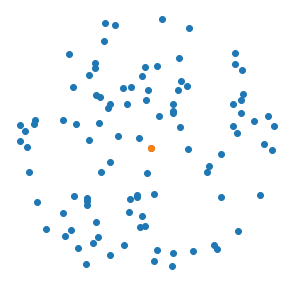

In [16]:
nearest = packet_nearest(packets, boxes, np.array([0,0]))

fig, ax = plt.subplots(figsize=(5,5))
plt.axis('off')
plot_points(pts)
plot_points(np.array([nearest]))

Testons maintenant les performances de notre nouvel algorithme de recherche de point le plus proche

In [17]:
packet_inputs = [[*split_pts(rand_in_disk(n), 2), rand_in_disk(1)[0]] for n in range(1, 1000)]

In [18]:
packet_perf = perf(packet_nearest, packet_inputs)

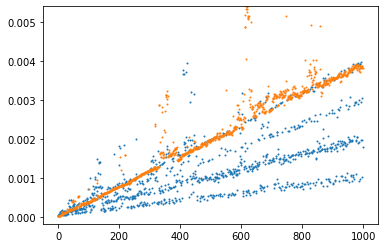

In [19]:
plot_array(packet_perf)
plot_array(naive_perf, filter_range=15)

On voit que comparé aux performances de l'algorithme naïf, dans le pire des cas le temps de calcul est à peu près le même que pour l'algorithme naïf, mais qu'on va jusqu'à quatre fois plus vite. On distingue nettement les quatres droites dans la complexité, selon que la requête testée a nécessité la visite d'une, deux, trois ou quatre paquets de points. La droite correspondant à deux boîtes semble être la plus fournie.

On pourrait se dire qu'en utilisant 8 boîtes au lieu de quatre on fait encore mieux.

In [20]:
packet_inputs = [[*split_pts(rand_in_disk(n), 4), rand_in_disk(1)[0]] for n in range(1, 1000)]

In [21]:
packet_perf = perf(packet_nearest, packet_inputs)

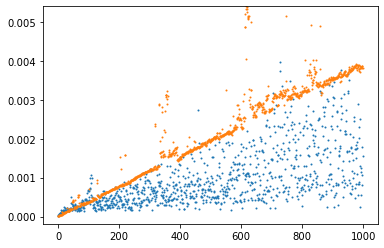

In [22]:
plot_array(packet_perf)
plot_array(naive_perf, filter_range=15)

Il faut néanmoins garder en tête que l'utilisation des boîtes n'est pas gratuite et introduit un surcoût : il faut calculer la distance aux boîtes. Au bout d'un moment, trop de boîtes tuent les performances.

In [23]:
box_size_inputs = [[*split_pts(rand_in_disk(1000), k), rand_in_disk(20)] for k in range(1, 30)]

In [24]:
def batch_packet_nearest(packets, boxes, queries):
    return [packet_nearest(packets, boxes, query) for query in queries]

box_size_perf = perf(batch_packet_nearest, box_size_inputs)

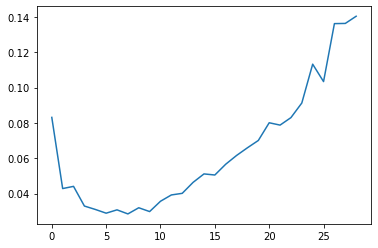

In [25]:
plot_array(box_size_perf, trace=True)

On voit bien ici que pour 1000 points, au delà d'une grille de boîtes de 5 par 5, les performances commencent à se dégrader. Avec une grille 5 par 5 le nuage de 1000 points est découpé comme suit.

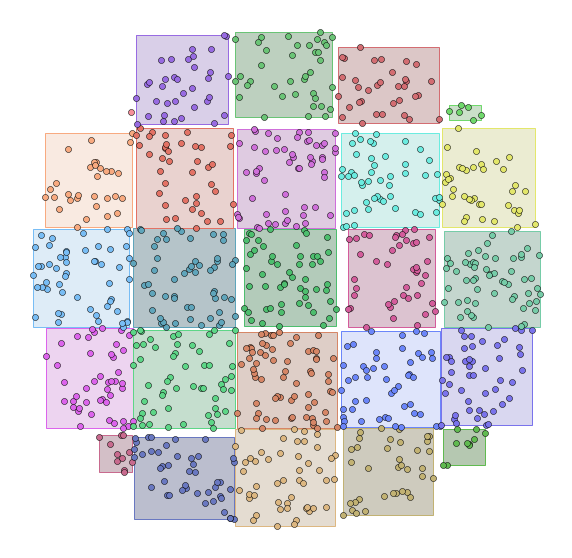

In [26]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')

for packet, box in zip(box_size_inputs[4][0], box_size_inputs[4][1]):
    c = rand_color()
    if box:
        box.draw(color=c)
        plot_points(packet, color=c, linewidth=.5, edgecolor='black')

La recherche ci-dessus utilisant une grille est naïve, une amélioration simple consiste à parcourir les boîtes dans un ordre dépendant de la position de la requête. En effet, plus le plus proche voisin est trouvé rapidement, plus les boîtes seront éliminées rapidement par une distance trop éloignée. Une méthode classique consiste à commencer par la boîte qui contient la requête, puis de faire un parcours en largeur de la grille à partir de cette boîte tant que les boîtes ne sont pas trop loin.

## Découpage hiérarchique, Bounding Volume Hierarchies (BVH)

L'approche hiérarchique consiste à mettre des boîtes dans des boîtes. Au fond, dans l'approche précédente, lorsqu'on a beaucoup de boîtes, l'algorithme dégénère en une recherche linéaire sur les boîtes. On peut alors se dire qu'on pourrait accélérer cette recherche en faisant à nouveau des paquets de boîtes dans de plus grosse boîtes. Énoncé dans l'autre sens, il s'agit de d'itérer l'approche par paquets : l'ensemble de points initial est découpé en gros paquets. Au lieu de faire une recherche linéaire sur ces gros paquets, on les divise eux-mêmes récursivement en plus petits paquets de points, dans des boîtes plus petites, qui eux-mêmes sont divisés en paquets, et ainsi de suite jusqu'à une limite sur la taille des paquets à partir de laquelle on fait une recherche linéaire. On obtient alors un arbre dont la racine correspond à l'ensemble de points, et chaque enfant d'un nœud correspond à une partie de ces points, avec la boîte qui les englobe. 

Il existe de très nombreuses stratégies pour déterminer les paquets à réaliser pour augmenter l'efficacité de la recherche. Ci-dessous nous utilisons une technique simple et classique. La découpe d'un nœud est réalisée en déterminant un plan de coupe perpendiculaire à un des axes (x, y ou z). Plus simplement on détermine une coordonnées, et une valeur, et tous les points ayant cette coordonnée plus petite que la valeur sont dans un enfant, les autres sont dans l'autre enfant. Ici, pour déterminer le plan de coupe, on utilise la dimension le long de laquelle la boîte du nœud est la plus allongée.

In [27]:
class BVH:
    def __init__(self, pts, minsize = 10):
        #stockage local du sous-ensemble des points
        self.pts = pts
        
        #calcul de la boîte englobante
        if pts.shape[0] > 0:
            self.box = Box(self.pts[0])
            for pt in self.pts:
                self.box.push(pt)
        
        #initialisation des enfants vides
        self.left = None
        self.right = None
        
        # subdivision
        self.split(minsize)
                
    def split(self, minsize = 10):
        #arrêt de la subdivision si trop peu de points
        if self.pts.shape[0] < minsize:
            return
        
        #axe le plus long de la boîte pour couper en deux
        axis = 0
        sizes = self.box.max - self.box.min
        if sizes[0] < sizes[1]:
            axis = 1
            
        #position de la coupe
        mid = 0.5*(self.box.min[axis] + self.box.max[axis])
        
        #pivot pour répartir les points de part et d'autre
        inf = 0
        sup = self.pts.shape[0] - 1
        while inf <= sup:
            #points plus petits que mid qui sont du bon côté
            while inf <= sup and self.pts[inf][axis] <= mid:
                inf += 1
            #points plus grands que mid qui sont du bon côté
            while sup >= inf and self.pts[sup][axis] > mid:
                sup -= 1
            #ici les deux points pointés sont tous les deux du mauvais côté
            #on les échange
            if inf < sup:
                self.pts[[inf, sup]] = self.pts[[sup, inf]]
                inf += 1
                sup -= 1
        
        #création des enfants
        self.left = BVH(self.pts[0:inf,:], minsize)
        self.right = BVH(self.pts[inf:, :], minsize)

    
    def draw(self):
        #affichage de la boîte englobante
        c = rand_color()
        self.box.draw(color=c)
        if self.left is not None:
            #affichge récursif des enfant
            self.left.draw() 
            self.right.draw()
        else:
            #pas d'enfants, affichage des points
            plot_points(self.pts, color=c, linewidth=.5, edgecolor="black")

In [28]:
tree = BVH(pts)

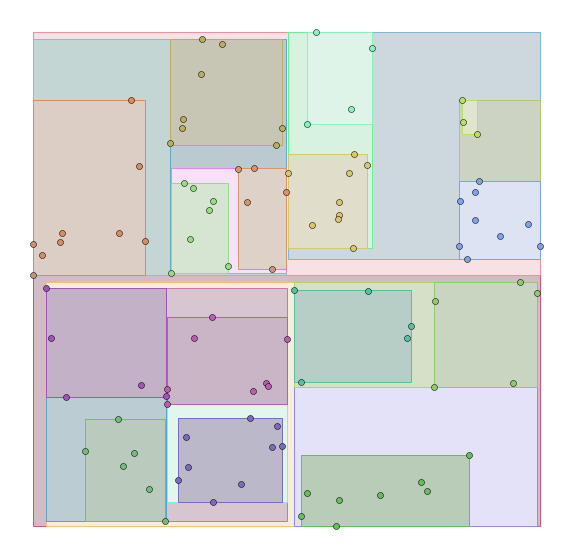

In [29]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
tree.draw()

La recherche est réalisée en réalisant un parcours en profondeur de l'arbre, mais en ne descendant que dans les nœuds qui sont suffisamment proches de la requête. De plus, à chaque nœud, la descente commence par l'enfant le plus proche de la requête.

In [30]:
class BVH(BVH):
    def nearest(self, query, candidate = None):
        #le candidat est trimbalé entre les appels récursifs 
        #il sert à garder le point le plus proche
        if candidate is None:
            candidate = [sq_distance(query, self.pts[0]), self.pts[0]]
        #vérification de la présence d'enfants
        if self.left is None and self.right is None:
            #pas d'enfants, test linéaire des points
            for pt in self.pts:
                d = sq_distance(pt, query)
                if d < candidate[0]:
                    candidate[0] = d
                    candidate[1] = pt
        else:
            #des enfants, descente récursive en commençant par l'enfant le plus proche
            children = [self.left, self.right]
            dc = [c.box.sq_distance(query) for c in children]
            if dc[1] < dc[0]:
                children = list(reversed(children))
                dc = list(reversed(dc))
            if dc[0] < candidate[0]:
                children[0].nearest(query, candidate)
                if dc[1] < candidate[0]:
                    children[1].nearest(query, candidate)

        #plus proche point au bout du compte
        return candidate[1]

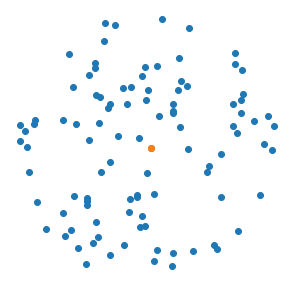

In [31]:
tree = BVH(pts)
nearest = tree.nearest([0,0])

fig, ax = plt.subplots(figsize=(5,5))
plt.axis('off')
plot_points(pts)
plot_points(np.array([nearest]))

Nous pouvons donc maintenant tester les performances de cette nouvelle approche. Notez que nous ne comptons pas ici dans le temps de calcul la création de l'arbre, en considérant que c'est un précalcul qui est amorti sur un grand nombre de recherches de plus proche voisin réalisées par la suite. Si le nombre de requêtes est faible, la création d'un tel arbre est alors absurde. En effet, chaque niveau de l'arbre correspond à un découpage de l'ensemble des points, et le calcul des boîtes englobantes de ce niveau a donc nécessité le parcours de l'ensemble des points. Si on considère que les points se répartissent équitablement à chaque découpe d'un nœud, la hauteur de l'arbre est alors le log du nombre de points, et la complexité de la création de l'arbre est donc de l'ordre de $n\log_2 n$ si $n$ est le nombre de points. Il faut donc au moins de l'ordre de $\log_2 n$ requêtes pour amortir ce coût de construction, sans quoi utiliser des recherches linéaires est plus rapide que de construire l'arbre.

In [32]:
tree_inputs = [[BVH(rand_in_disk(n)), rand_in_disk(10)] for n in range(1, 1000)]

In [33]:
def batch_tree_nearest(tree, queries):
    return [tree.nearest(q) for q in queries]

tree_perf = perf(batch_tree_nearest, tree_inputs)

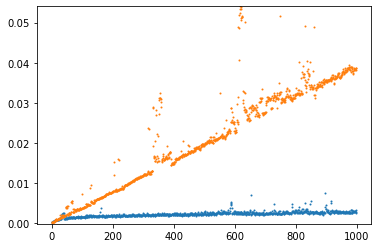

In [34]:
plot_array(tree_perf)
plot_array(10*naive_perf, filter_range=15)

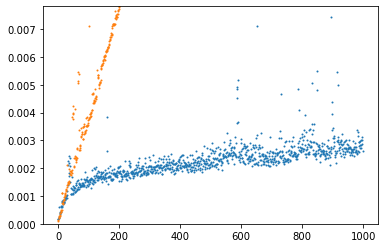

In [35]:
plt.ylim(0, np.max(tree_perf)*1.05)
plot_array(tree_perf)
plot_array(10*naive_perf)

On constate sur la courbe ici que le temps de calcul semble être de l'ordre du log du nombre de points. 

## Intersection rayon objet

Beaucoup de requêtes spatiales peuvent être accélérées avec le même principe. En gros pour que la technique de la hérarchie de volumes englobant, il est nécessaire :

1. qu'il soit facile de calculer un englobant sur les objets
1. que la requête soit telle qu'un test sur l'englobant permette d'éliminer son contenu
1. qu'il soit facilement possible de réaliser le test sur l'englobant

Typiquement, pour la synthèse d'images, la brique de base de toutes les méthodes de rendu est le lancer de rayons, qui nécessite de pouvoir calculer l'intersection entre un rayon et les objets de la scène. Cette requête se prête très bien à la subdivision spatiale, car :

1. il est facile de mettre des triangles dans des englobants
1. il est facile de faire un test d'intersection rayon / boîte ou rayon / boule
1. pour intersecter un objet, un rayon doit intersecter la boîte qui le contient

Ci dessous nous allons illustrer ce principe sur une scène 2D composée de disques.

In [36]:
class Ball:
    def __init__(self, generate = True, **kwargs):
        self.center = None
        self.radius = None
        if generate:
            self.set_random(**kwargs)
    
    def set_random(self, min_radius = 0.01, max_radius = 0.1):
        self.center = rand_in_disk(1)[0]
        self.radius = np.random.uniform(min_radius, max_radius)

    def draw(self, color = None, **kwargs):
        if color is None:
            color = rand_color()
        c = plt.Circle(self.center, self.radius, facecolor=color, edgecolor='black', linewidth=1, **kwargs)
        ax = plt.gcf().gca()
        ax.autoscale_view()
        ax.add_patch(c)

In [37]:
balls = np.array([Ball() for _ in range(50)])

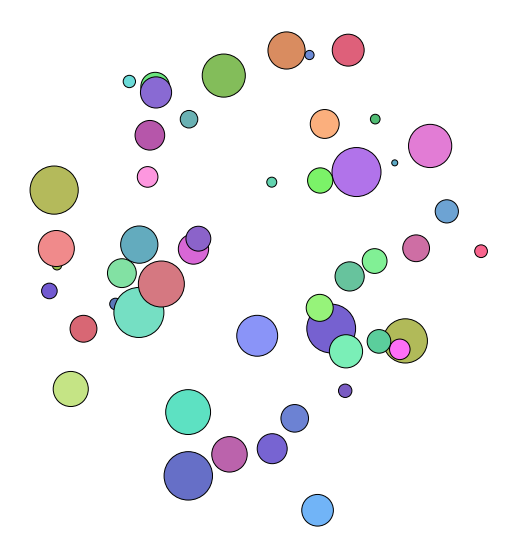

In [38]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')

for ball in balls:
    ball.draw()
plt.show()

On peut facilement adapter le code des boîtes englobantes alignées sur les axes pour contenir des disques plutôt que des points.

In [39]:
# A circle is encoded as a 3D point, the third dimension being its radius

class Box(Box):
    def push_ball(self, ball):
        self.min = np.minimum(self.min, ball.center - ball.radius)
        self.max = np.maximum(self.max, ball.center + ball.radius)

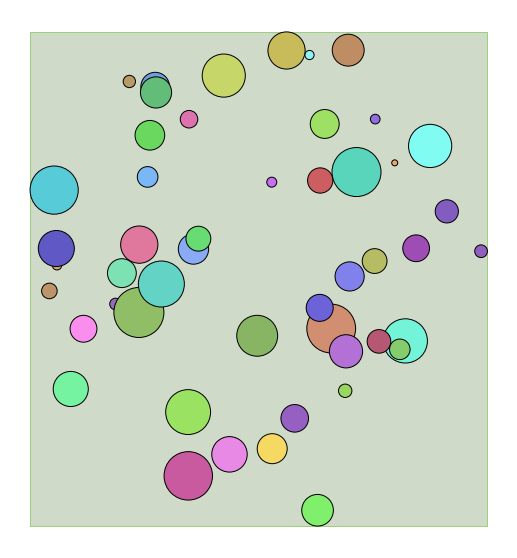

In [40]:
b = Box(balls[0].center)
for ball in balls:
    b.push_ball(ball)
    
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')

for ball in balls:
    ball.draw()
b.draw()

Un rayon est carractérisé par :
* une origine
* une direction

Il contient tous les points de la demi-droite issue de l'origine, dans la direction donnée.

In [41]:
class Ray:
    def __init__(self, generate = True):
        self.origin = None
        self.direction = None
        if generate:
            self.set_random()
    
    def set_random(self):
        self.origin = rand_in_disk(1)[0]
        self.direction = rand_directions(1)[0]
        
    def draw(self, color=None, line = False, **kwargs):
        z = 0
        if 'zorder' in kwargs:
            z = kwargs['zorder']
        if color is None:
            color = rand_color()
        plt.scatter(
            [self.origin[0]], [self.origin[1]], 
            marker='o', linewidth=2, edgecolor=color, facecolor='none', s=100, zorder = z+1
        )
        plt.quiver(
            [self.origin[0]], [self.origin[1]], 
            [self.direction[0]], [self.direction[1]], 
            color=color, headlength=4, zorder = z+1
        )
        if line:
            outpoint = self.origin + 3*self.direction
            line = matplotlib.collections.LineCollection(
                [np.stack([self.origin, outpoint])],
                zorder=z,
                color=color,
                linestyle='dashed'
            )
            plt.gcf().gca().add_collection(line, autolim=False)

In [42]:
rays = np.array([Ray() for _ in range(30)])

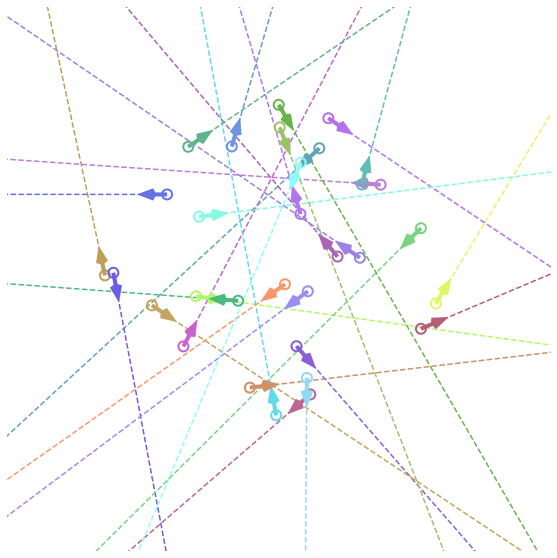

In [43]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')
plt.ylim(-1.5, 1.5)
plt.xlim(-1.5, 1.5)

for r in rays:
    r.draw(line=True)
plt.show()

Pour calculer l'intersection entre une sphère (ici en 2D un cercle mais le même code fonctionne en 3D) et un rayon, il faut commencer par exprimer mathématiquement ce que signifie pour un point être sur un rayon et être sur une sphère. Si $\mathbf{o}$ est l'origine du rayon et si $\mathbf{d}$ est sa direction, un point $\mathbf{p}$ est sur le rayon s'il peut s'écrire comme

$$ \mathbf{p} = \mathbf{o} + t \mathbf{d}, $$

avec $t$ un réel positif. À chaque valeur de $t$ correspond un unique point du rayon. Plus $t$ est élevé, plus le point est loin de l'origine. Si $\mathbf{c}$ est le centre de la sphère et si $r$ est son rayon, un point est sur la sphère s'il est à une distance $r$ du centre :

$$ \lVert \mathbf{p} - \mathbf{c} \rVert = r. $$

Il est néanmoins plus facile de travailler avec le carré de la distance, pour éviter la racine carrée dans son expression :

$$ \lVert \mathbf{p} - \mathbf{c} \rVert^2 = r^2. $$

Cette expression est équivalente à la précédente car nous savons que la distance et le rayon de la sphère sont positifs. Si le rayon intersecte la sphère, le point d'interserction doit donc respecter ces deux contraintes. Nous obtenons donc le problème suivant : chercher $t \geq 0$ tel que les deux contraintes soient respectées.En combinant les deux expressions, nous obtenons l'équation à résoudre :

$$ \lVert \mathbf{o} + t \mathbf{d} - \mathbf{c} \rVert^2 = r^2. $$

La norme au carré d'un vecteur $\mathbf{v}$ peut être exprimée via le produit scalaire $\lVert \mathbf{v} \rVert^2 = \mathbf{v}.\mathbf{c}$. Nous obtenons ainsi

$$ (\mathbf{o} + t \mathbf{d} - \mathbf{c}).(\mathbf{o} + t \mathbf{d} - \mathbf{c}) = r^2 $$

et en développant

$$ \lVert \mathbf{o} - \mathbf{c} \rVert^2 - 2t(\mathbf{o} - \mathbf{c}).\mathbf{d} + t^2\lVert \mathbf{d} \rVert^2 = r^2 $$

nous obtenons ainsi une équation du second degré en $t$, que l'on peut écrire classiquement en

$$  \lVert \mathbf{d} \rVert^2 t^2 - 2(\mathbf{o} - \mathbf{c}).\mathbf{d}t + \lVert \mathbf{o} - \mathbf{c} \rVert^2 - r^2 = 0 $$

Selon le discriminant, nous obtiendrons soit aucune solution (pas d'intersection), soit une solution (rayon tageant à la sphère, cas particulier), ou deux solutions. Seules les solutions où $t$ est positif sont à conserver, car les autres sont derrière l'origine du rayon.

In [44]:
def ray_ball_intersection(ray, ball):
    # coefficients de l'équation du second degré
    a = np.dot(ray.direction, ray.direction)
    v = ball.center - ray.origin
    b = np.dot(-2*v, ray.direction)
    c = np.dot(v, v) - ball.radius * ball.radius
    # discriminant
    delta = b * b - 4 * a * c
    if delta > 0:
        # des solutions existent
        sqd = math.sqrt(delta)
        t1 = (-b - sqd) / (2 * a)
        t2 = (-b + sqd) / (2 * a)
        hits = np.array([t for t in [t1, t2] if t > 0])
        if len(hits) > 0:
            if len(hits) == 2:
                return min(hits) 
            return 0
    return None

def hit_point(ray, t):
    return ray.origin +t * ray.direction

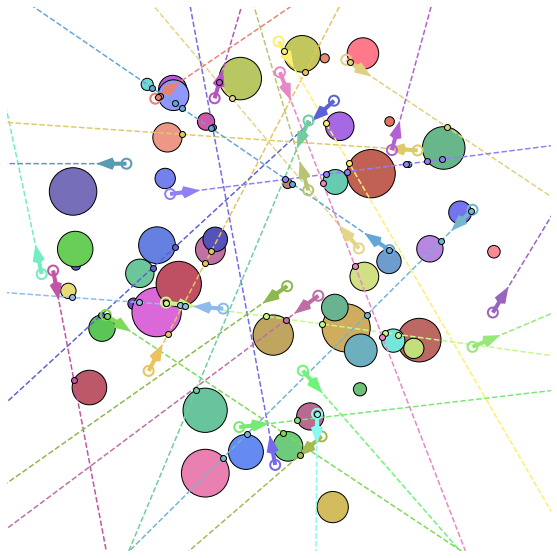

In [45]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

for ball in balls:
    ball.draw(zorder = -1)

for ray in rays:  
    color=rand_color()
    ray.draw(color=color, line=True)
    for ball in balls:
        t = ray_ball_intersection(ray, ball)
        if t is not None:
            plot_points(np.array([hit_point(ray, t)]), color=color, linewidth=1, edgecolor="black")
plt.show()

En synthèse d'image, on cherche souvent à résoudre le problème de la visibilité : étant donné un rayon et un ensemble d'objets, quel est le premier objet touché par le rayon. C'est par exemple la requête que l'on fait pour déterminer les objets vus par la caméras, en lançant des rayons depuis la caméra.

![un lancer de rayons depuis une caméra](Images/ray_tracing.png)

Pour calculer cette première intersection, un algorithme naïf consiste à calculer toutes les intersection, puis ne garder que la plus proche.

In [46]:
def raytrace_balls_naive(ray, balls):
    t = None
    for ball in balls:
        i = ray_ball_intersection(ray, ball)
        if i is not None:
            hit = np.min(i)
            if t is None or hit < t:
                t = hit
    return t

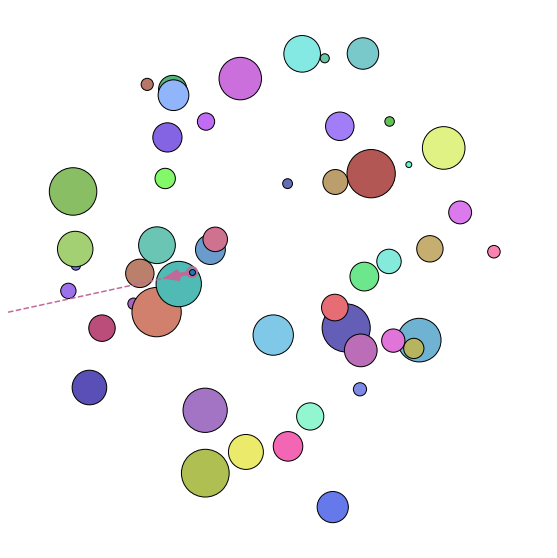

In [47]:
ray = None
hit = None
while hit is None:
    ray = Ray()
    hit = raytrace_balls_naive(ray, balls)
    
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

ray.draw(line = True)
for ball in balls:
    ball.draw(zorder = -1)
plot_points(np.array([hit_point(ray, hit)]), linewidth=1, edgecolor="black")
    
plt.show()

Cette approche est linéaire en le nombre de sphères à tester, comme on peut s'en douter.

In [48]:
ball_inputs = [(Ray(), [Ball() for _ in range(i)]) for i in range(1,1000)]

In [49]:
raytrace_naive_perf = perf(raytrace_balls_naive, ball_inputs)

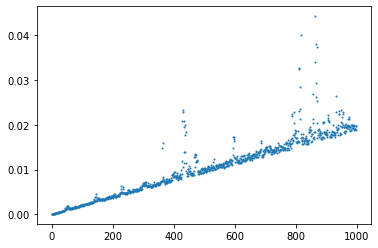

In [50]:
plot_array(raytrace_naive_perf)

De même que pour les points, on peut disposer les sphères dans une hiérarchie de volumes englobants. Il faut ici déterminer comment répartir les sphères en fonction de la position de découpe, car une sphère peut être  des deux côtés de la coupe. Ici nous avons choisi de ne considérer que le centre de la sphère pour la répartition.

In [51]:
class BallBVH:
    def __init__(self, balls, minsize = 10):
        #stockage local du sous-ensemble des points
        self.balls = balls
        
        #calcul de la boîte englobante
        if balls.shape[0] > 0:
            self.box = Box(self.balls[0].center)
            for ball in self.balls:
                self.box.push_ball(ball)
        
        #initialisation des enfants vides
        self.left = None
        self.right = None
        
        # subdivision
        self.split(minsize)
                
    def split(self, minsize = 10):
        #arrêt de la subdivision si trop peu de points
        if self.balls.shape[0] < minsize:
            return
        
        #axe le plus long de la boîte pour couper en deux
        axis = 0
        sizes = self.box.max - self.box.min
        if sizes[0] < sizes[1]:
            axis = 1
            
        #position de la coupe
        mid = 0.5*(self.box.min[axis] + self.box.max[axis])
        
        #pivot pour répartir les points de part et d'autre
        inf = 0
        sup = self.balls.shape[0] - 1
        while inf <= sup:
            #points plus petits que mid qui sont du bon côté
            while inf <= sup and self.balls[inf].center[axis] <= mid:
                inf += 1
            #points plus grands que mid qui sont du bon côté
            while sup >= inf and self.balls[sup].center[axis] > mid:
                sup -= 1
            #ici les deux points pointés sont tous les deux du mauvais côté
            #on les échange
            if inf < sup:
                self.balls[[inf, sup]] = self.balls[[sup, inf]]
                inf += 1
                sup -= 1
                
        
        
        #création des enfants
        if inf == 0 or inf == self.balls.shape[0]:
            inf = int(self.balls.shape[0] / 2)
        self.left = BallBVH(self.balls[0:inf], minsize)
        self.right = BallBVH(self.balls[inf:], minsize)

    
    def draw(self):
        #affichage de la boîte englobante
        c = rand_color()
        self.box.draw(color=c, alpha = 0.5)
        if self.left is not None:
            #affichge récursif des enfant
            self.left.draw() 
            self.right.draw()
        else:
            #pas d'enfants, affichage des points
            for ball in self.balls:
                ball.draw()

In [52]:
ball_tree = BallBVH(balls, minsize = 5)

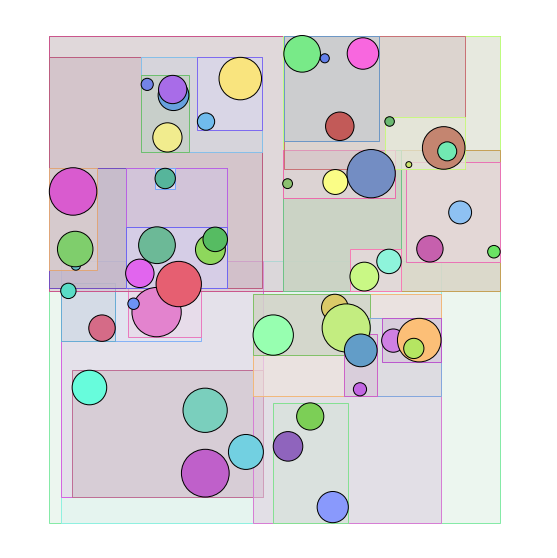

In [53]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

ball_tree.draw()
plt.show()

Pour pouvoir exploiter notre arbre pour des requêtes de lancer de rayons, il est nécessaire de pouvoir déterminer si un rayon passe dans une boîte ou non. S'il ne passe pas, il ne pourra pas non-plus rencontrer le contenu de cette boîte. L'intersection entre un rayon et une boîte consiste à calculer pour chaque axe l'intersection entre le rayon et la tranche d'espace contenue entre les deux bornes de la boîte. Pour la coordonnées $x$ et la borne inférieure $x_{min}$ de la boîte par exemple, on résoud :

$$
o_x + t d_x = x_{min} \Leftrightarrow t = \frac{x_{min} - o_x}{d_x}
$$

où $o_x$ est la coordonnée $x$ de l'origine du rayon et $d_x$ celle de sa direction. On obtient alors pour chaque coordonnée un intervalle $[t_{min}, t_{max}]$ pour lequel le rayon traverse la tranche d'espace comprise entre les deux bornes de la boîte. Un rayon traverse la boîte si l'intersection entre les intervalles sur chaque axe est non vide. Il suffit donc de vérifier que le maximum des $t_{min}$ sur toutes les coordonnées est toujours plus petit que le minimum des $t_{max}$ pour toutes les coordonnées.

In [54]:
class Box(Box):
    def raytrace(self, ray, tmax = None):
        # a ray is define as the set of points origin + t*direction
        # the ray inersects each dimension slice as a segment, by solving
        # origin[dim] + t * direction[dim] = bound
        # => t = (bound - origin[dim]) / direction[dim]
        min_bounds = (self.min - ray.origin) / ray.direction
        max_bounds = (self.max - ray.origin) / ray.direction
        min_interval = np.minimum(min_bounds, max_bounds)
        max_interval = np.maximum(min_bounds, max_bounds)
        m = np.max(min_interval)
        M = np.min(max_interval)
        if m < M and M > 0:
            hit = m if m > 0 else 0
            if tmax is None or hit < tmax:
                return hit
        return tmax

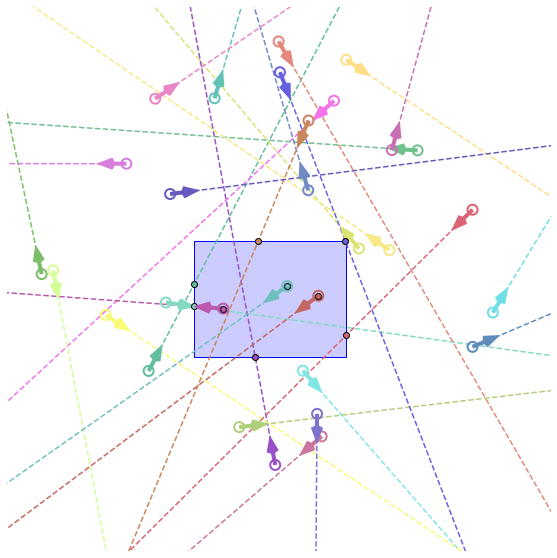

In [55]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)


b = Box(rand_in_disk(1, [-0.3,-0.3], 0.2)[0])
b.push(rand_in_disk(1, [0.3,0.3], 0.2)[0])
b.draw(color="blue")

for ray in rays:  
    color=rand_color()
    ray.draw(color=color, line=True, zorder = 1)
    hit = b.raytrace(ray)
    if hit is not None:
        plot_points(np.array([hit_point(ray, hit)]), color=color, linewidth=1, edgecolor="black", zorder=2)
plt.show()

Nous pouvons maintenant exprimer la traversée de l'arbre pour exploiter sa structure. Ici nous avons de multiples cas à traiter.

In [56]:
class BallBVH(BallBVH):
    def raytrace(self, ray, tmax = None):
        if self.left:
            h1 = self.left.box.raytrace(ray, tmax)
            h2 = self.right.box.raytrace(ray, tmax)
            if h1 == tmax:
                #pas d'intersection avec l'enfant gauche
                if h2 == tmax:
                    #pas d'intersection avec l'enfant droit, on ne va pas plus loin
                    return tmax
                #intersection uniquement avec l'enfant droit, on ne parcourt que de ce côté.
                return self.right.raytrace(ray, tmax)
            if h2 == tmax:
                #intersection uniquement avec l'enfant gauche, on ne parcourt que de ce côté.
                return self.left.raytrace(ray, tmax)
            #à partir d'ici les deux enfants sont traversés par le rayon
            if h1 < h2:
                #gauche est traversé avant droit, on descend de ce côté d'abord
                hit = self.left.raytrace(ray ,tmax)
                if hit == tmax or h2 < hit:
                    #il reste nécessaire de parcourir à droite
                    return self.right.raytrace(ray, hit)
                #droit est désormais trop loin après avoir parcouru gauche
                return hit
            else:
                #droit est traversé avant gauche, on descend de ce côté d'abord
                hit = self.right.raytrace(ray ,tmax)
                if hit == tmax or h1 < hit:
                    #il reste nécessaire de parcourir à gauche
                    return self.left.raytrace(ray, hit)
                #gauche est désormais trop loin après avoir parcouru droit
                return hit
        else:
            #pas d'enfants, test linéaire
            hit = tmax
            for ball in self.balls:
                h = ray_ball_intersection(ray, ball)
                if h is not None:
                    if hit is None or h < hit:
                        hit = h
            return hit

In [57]:
ball_tree = BallBVH(balls, minsize = 3)

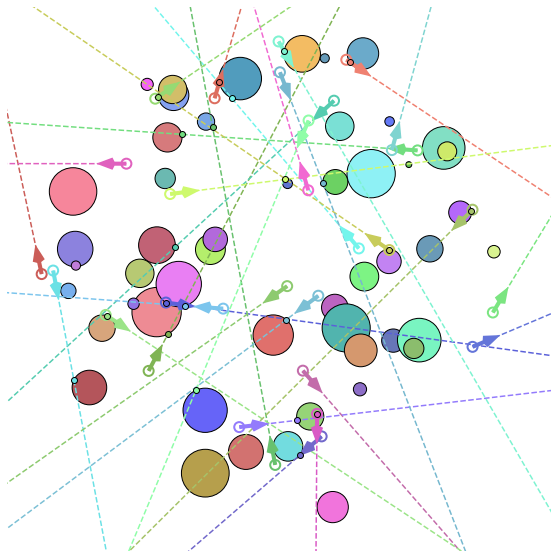

In [58]:
fig, ax = plt.subplots(figsize=(10,10))
plt.axis('off')
ax.set_aspect('equal')
plt.ylim(-1.1, 1.1)
plt.xlim(-1.1, 1.1)

for ball in balls:
    ball.draw(zorder = -1)

for ray in rays:  
    color=rand_color()
    ray.draw(color=color, line=True, zorder = 1)
    hit = ball_tree.raytrace(ray)
    if hit is not None:
        plot_points(np.array([hit_point(ray, hit)]), color=color, linewidth=1, edgecolor="black", zorder=2)

plt.show()

In [59]:
ball_tree_inputs = [[BallBVH(np.array([Ball() for _ in range(n)]), 5), [Ray() for _ in range(10)]] for n in range(1, 1000)]

In [60]:
def batch_ball_tree_raytrace(tree, queries):
    return [tree.raytrace(q) for q in queries]

ball_tree_perf = perf(batch_ball_tree_raytrace, ball_tree_inputs)

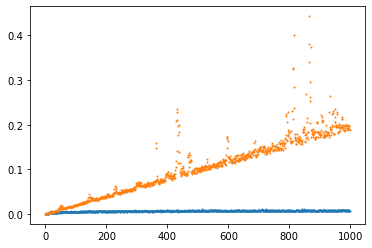

In [61]:
plot_array(ball_tree_perf)
plot_array(10*raytrace_naive_perf)

On voit de nouveau des performances qui semblent confirmer une complexité de l'ordre de $O(\log{n})$.